In [10]:
import process as pc
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import joblib
import cv2

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [11]:
def print_image(image, keypoints):
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    for kp in keypoints:
        rect = patches.Rectangle((kp[0]-40, kp[1]-40), kp[0]+40, kp[1]+40, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show();

In [12]:
pipeline_save_path = pc.DATA_PATH+"/hog_features_preprocess.pkl"
image_path = pc.DATA_PATH+"/final/totti_del_piero.jpg"

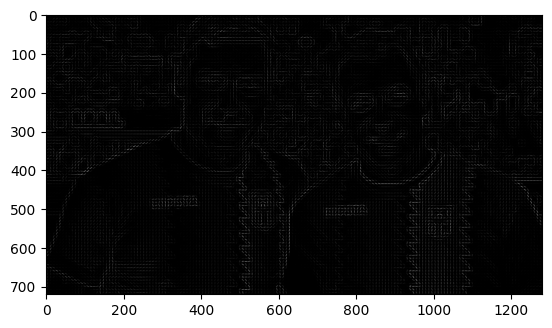

In [13]:
from skimage.feature import hog
image = cv2.imread(image_path)
image = pc.process_image(image)
features, hog_img = hog(image, visualize=True)
plt.imshow(hog_img, cmap='gray')

[0] [0.05345244]


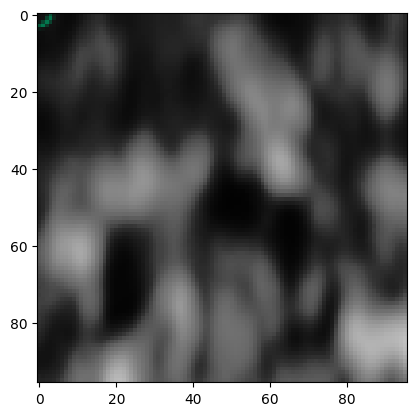

[]
[0] [0.09386587]


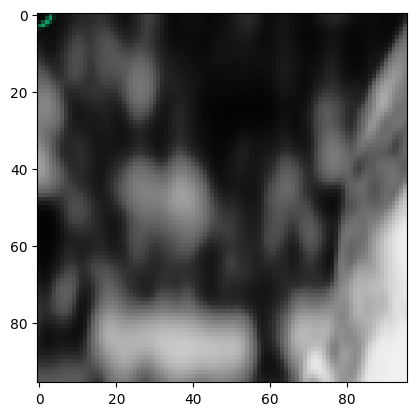

[]
[0] [0.24878855]


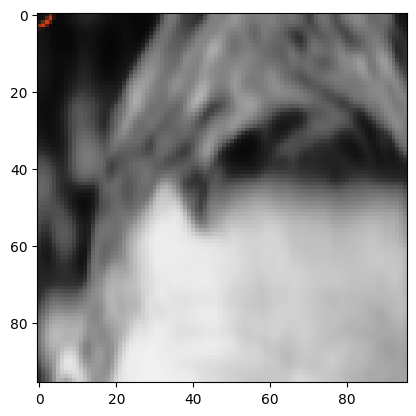

[]
[0] [0.02214237]


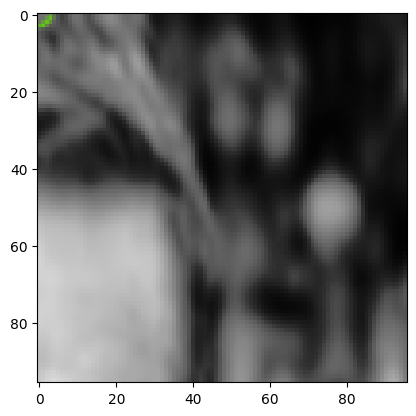

[]
[0] [0.05064074]


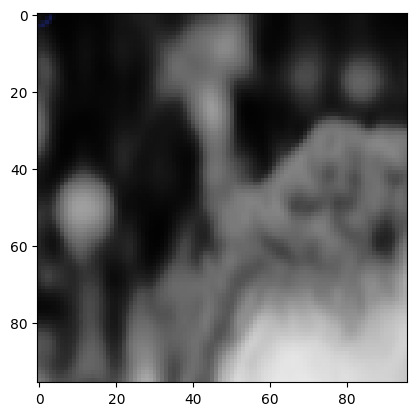

[]
[0] [0.04562381]


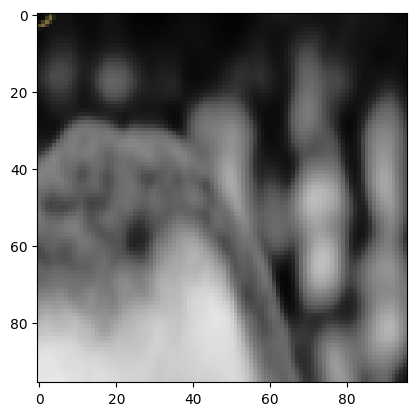

[]
[0] [0.05341674]


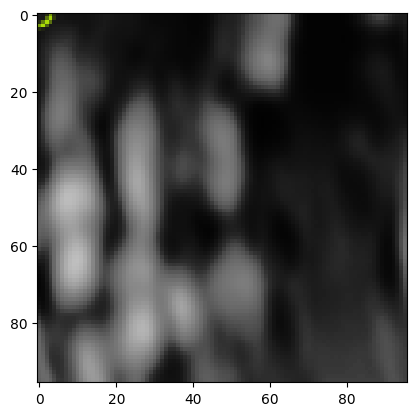

[]
[0] [0.02396292]


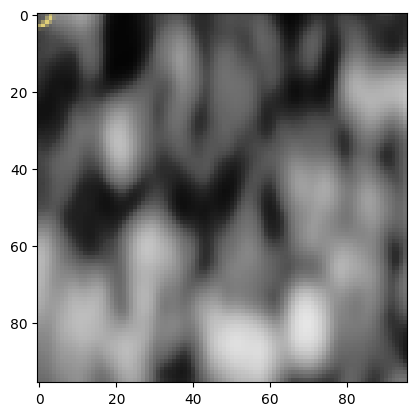

[]
[0] [0.16108125]


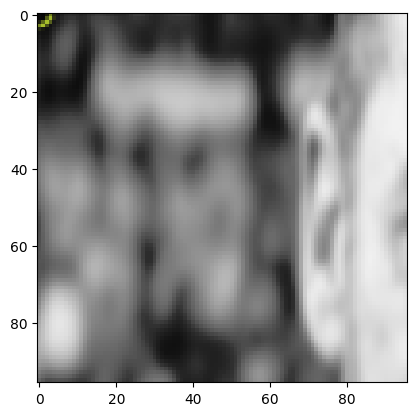

[]
[0] [0.31045991]


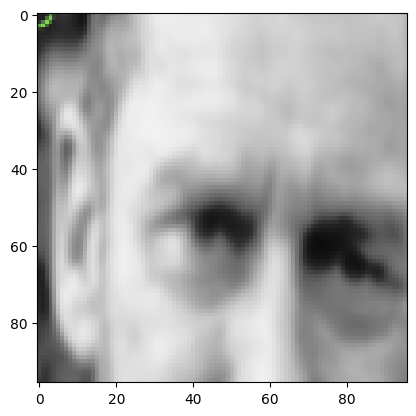

[]
[0] [0.01959062]


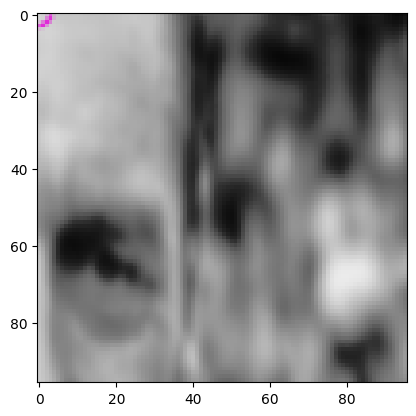

[]
[0] [0.13499403]


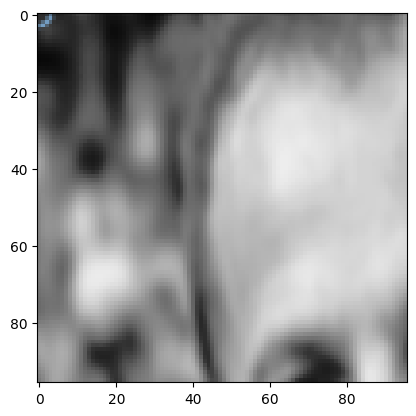

[]
[0] [0.2570798]


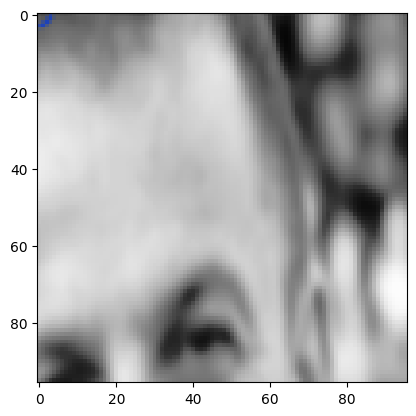

[]
[0] [0.03599173]


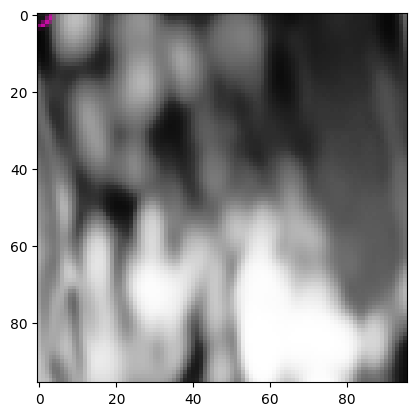

[]
[0] [0.06858035]


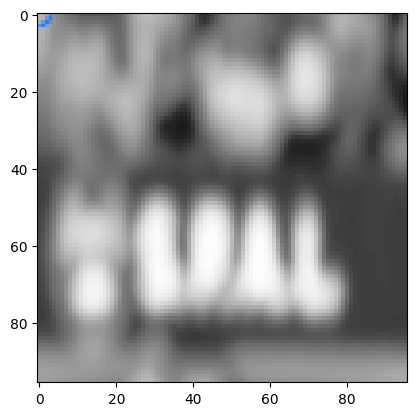

[]
[0] [0.03002609]


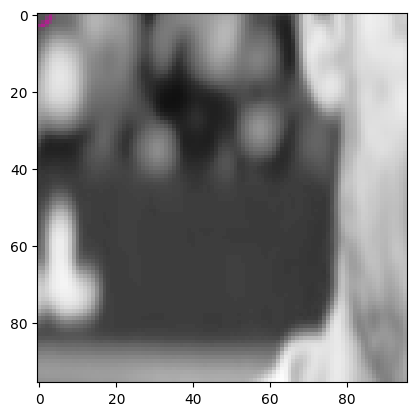

[]
[0] [0.08190399]


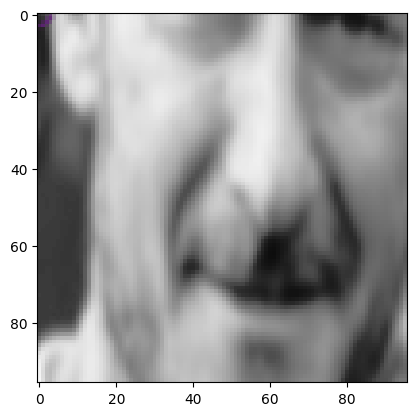

[]
[0] [0.31774435]


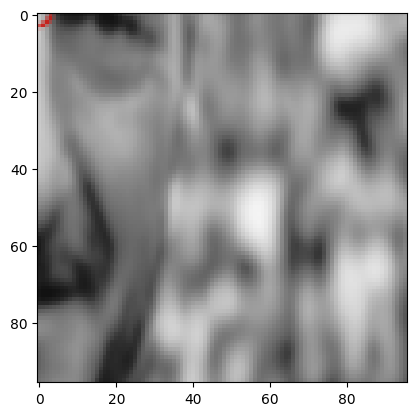

[]
[0] [0.09663192]


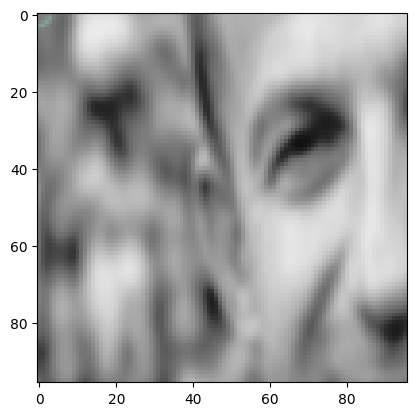

[]
[0] [0.03765757]


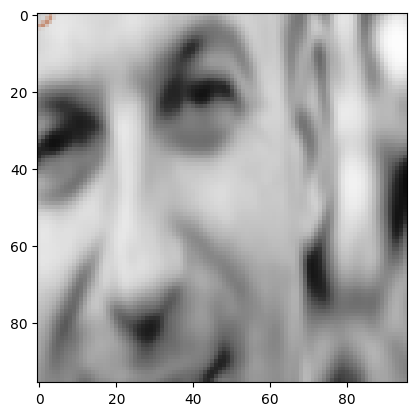

[]
[0] [0.18300657]


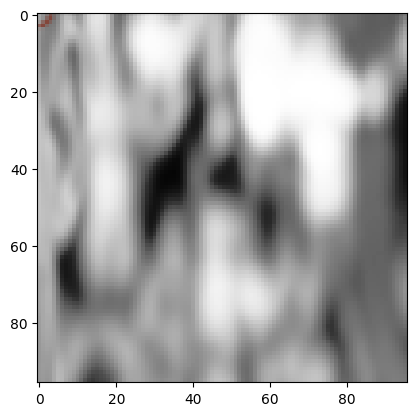

[]
[0] [0.07483185]


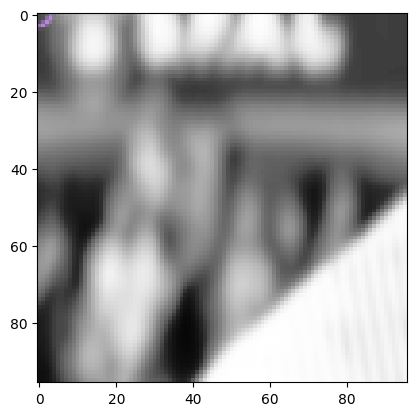

[]
[0] [0.35526548]


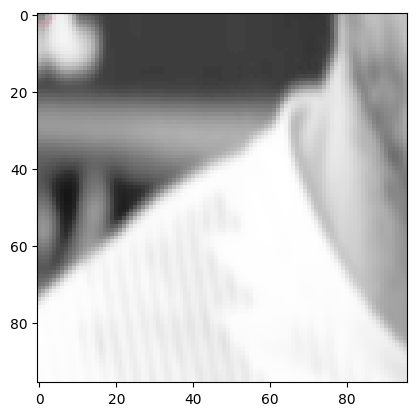

[]
[0] [0.23834922]


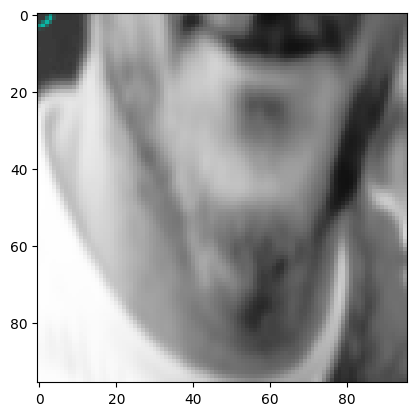

[]
[0] [0.06665685]


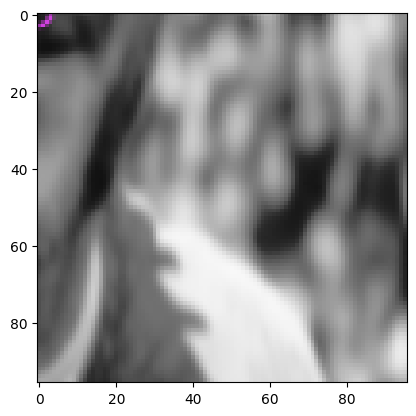

[]
[0] [0.30225915]


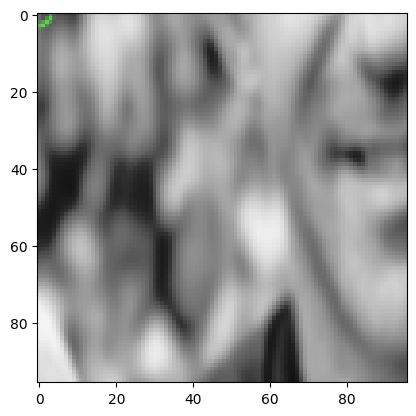

[]
[0] [0.04479761]


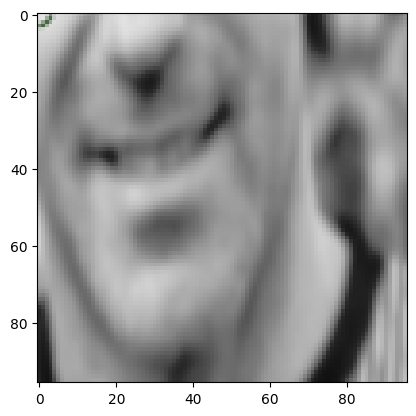

[]
[0] [0.17011994]


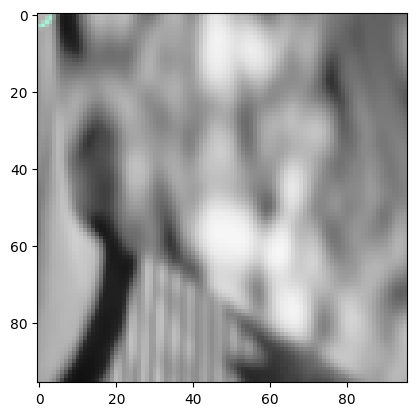

[]
[0] [0.09209736]


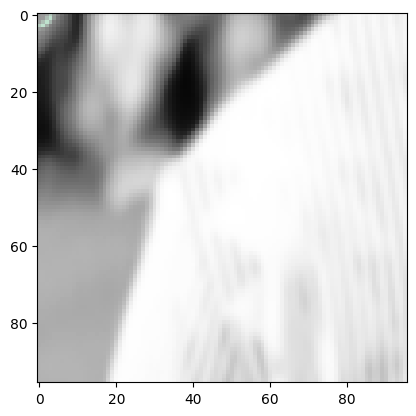

[]
[0] [0.15991095]


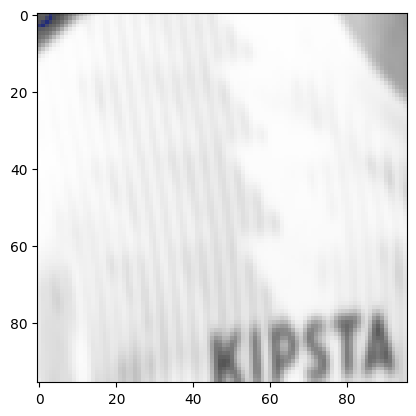

[]
[0] [0.08089914]


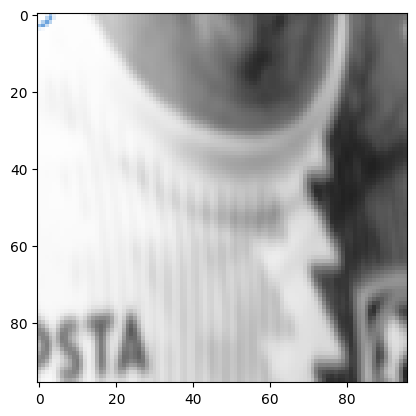

[]
[0] [0.13606101]


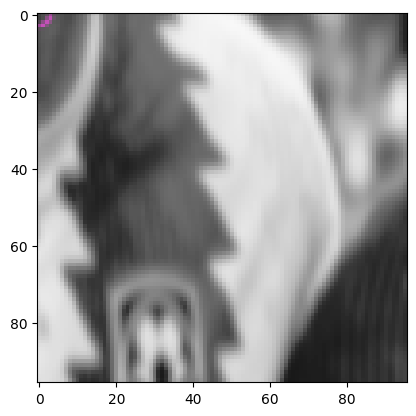

[]
[0] [0.34584564]


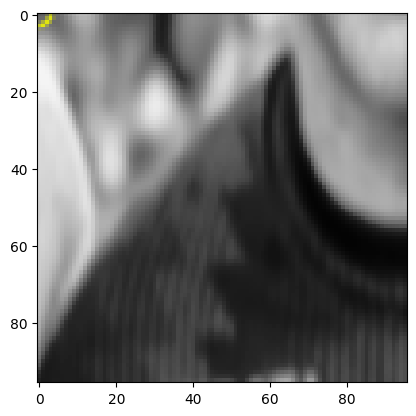

[]
[0] [0.0213341]


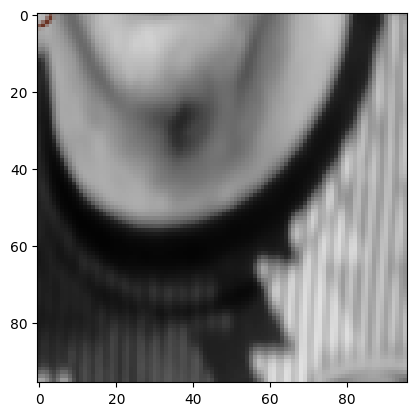

[]
[0] [0.34827508]


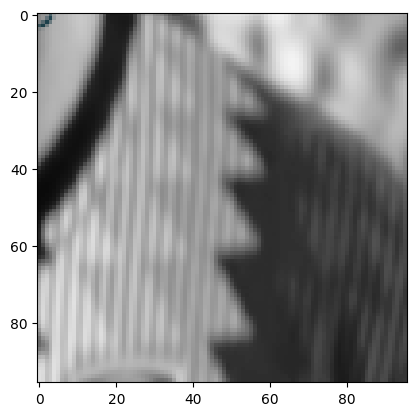

[]
[0] [0.07279896]


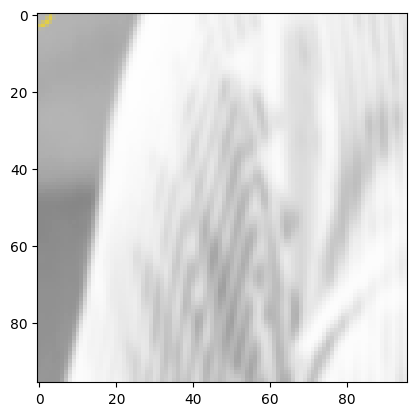

[]
[0] [0.0346653]


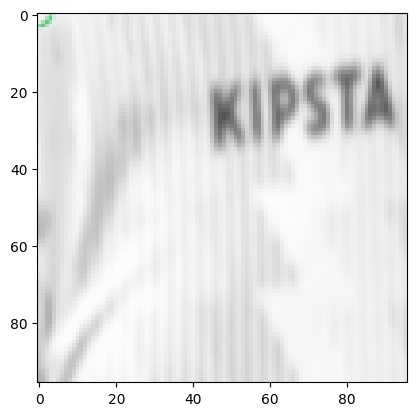

[]
[0] [0.05372255]


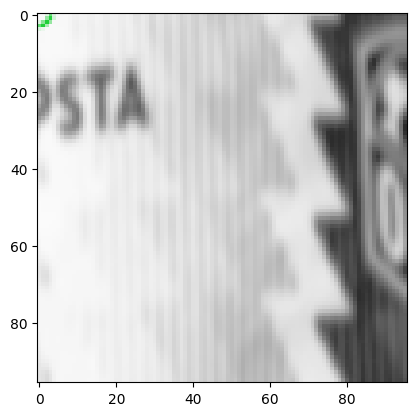

[]
[0] [0.03648319]


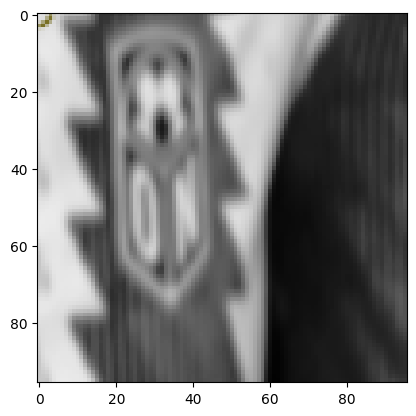

[]
[0] [0.15848994]


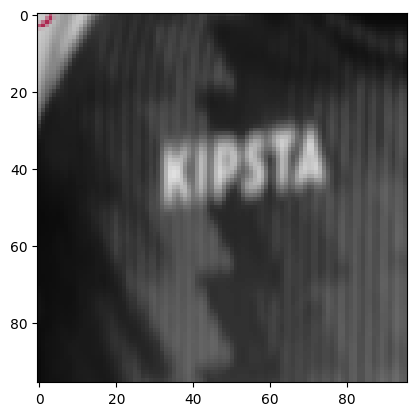

[]
[0] [0.28859898]


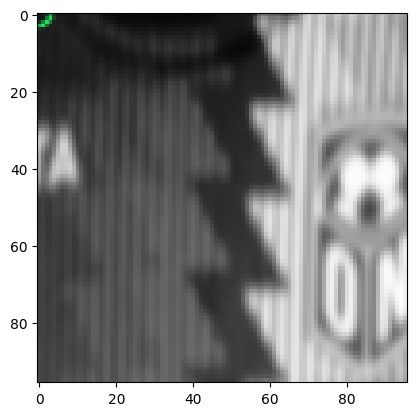

[]
[0] [0.14952614]


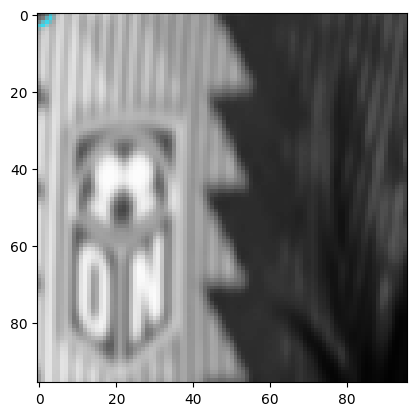

[]
[0] [0.07955312]


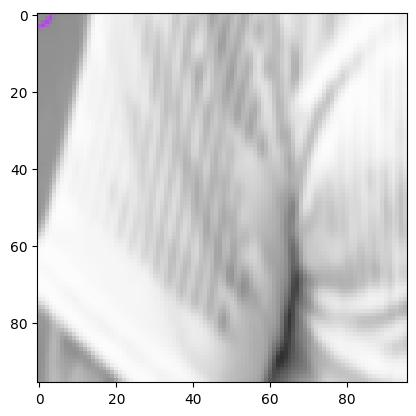

[]
[0] [0.04664051]


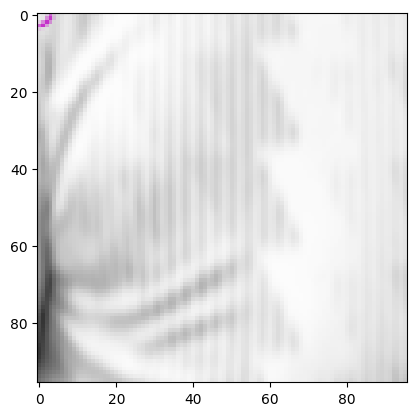

[]
[0] [0.03087113]


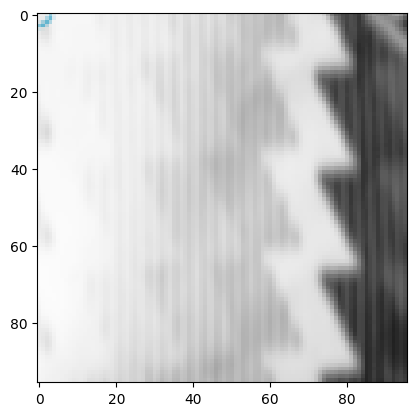

[]
[0] [0.05106745]


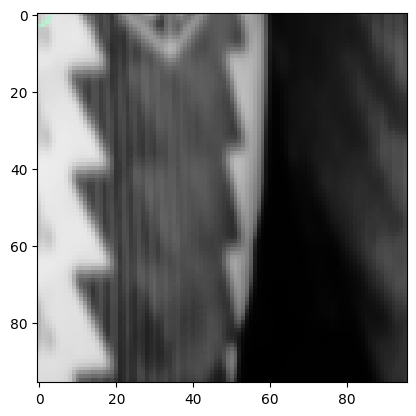

[]
[0] [0.01551985]


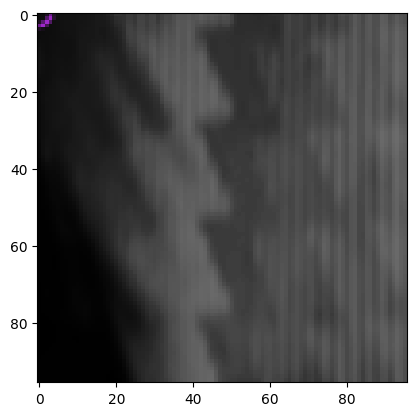

[]
[0] [0.05879611]


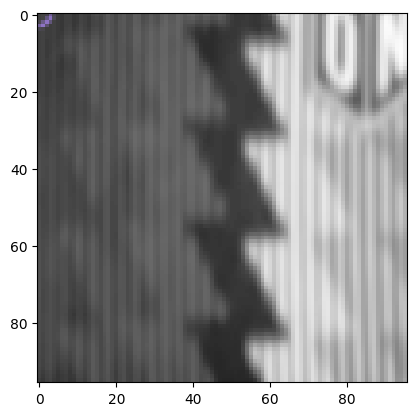

[]
[0] [0.20803715]


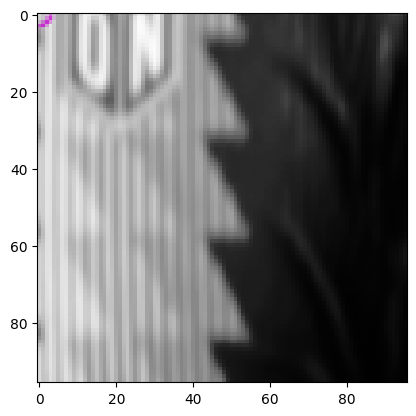

[]


[]

In [14]:
image = cv2.imread(image_path)
pipeline = joblib.load(pipeline_save_path)
keypoints, _ = pc.detect_faces(image, pipeline, method='HOG', threshold=0.6, window_size=(96, 96), step_size=(64, 64),\
                                n_keypoints=8100, resize=True, image_size=(512, 512), verbose=True, notebook=True)
keypoints

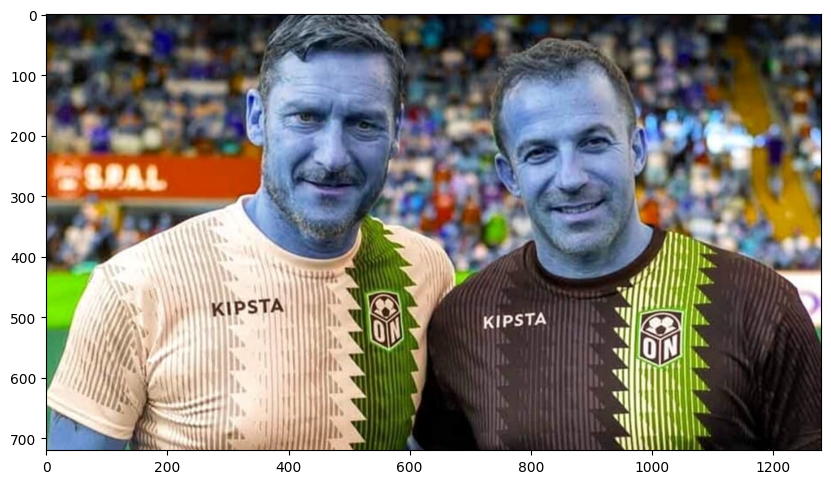

In [15]:
print_image(image, keypoints)

[0] [0.00111452]


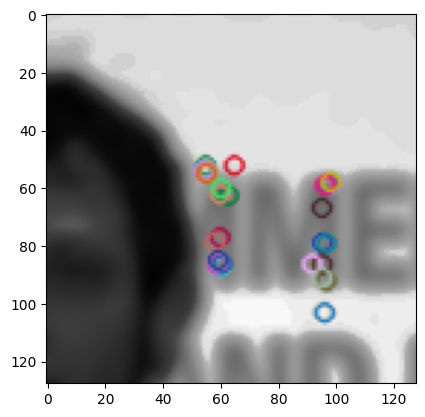

[]
[0] [0.58049499]


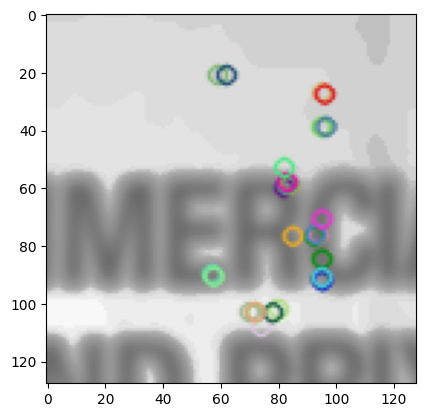

[]
[0] [0.00946672]


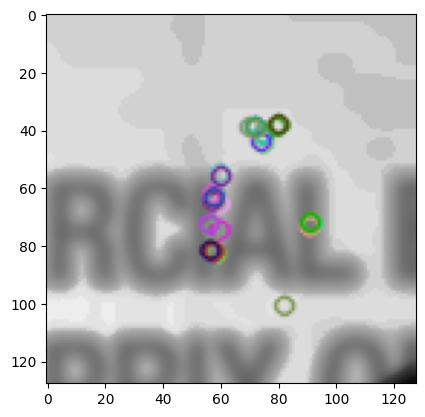

[]
[0] [0.02216585]


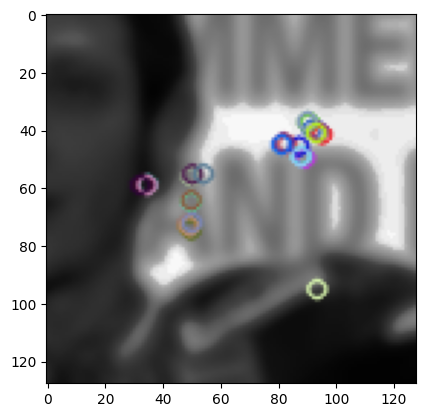

[]
[0] [0.07010199]


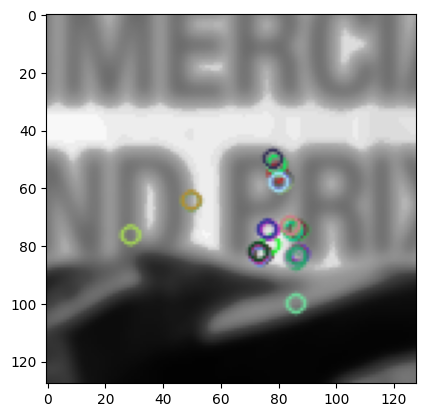

[]
[0] [0.04418086]


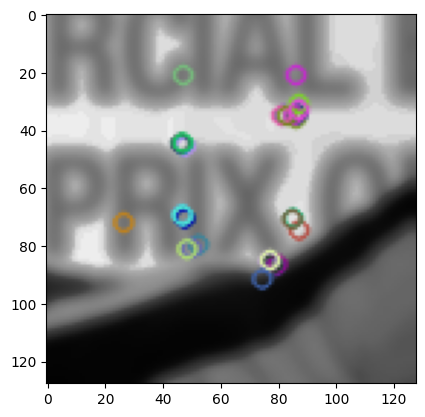

[]
[0] [0.5303348]


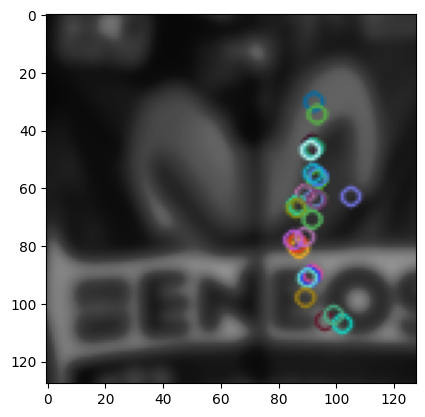

[]
[0] [0.2063465]


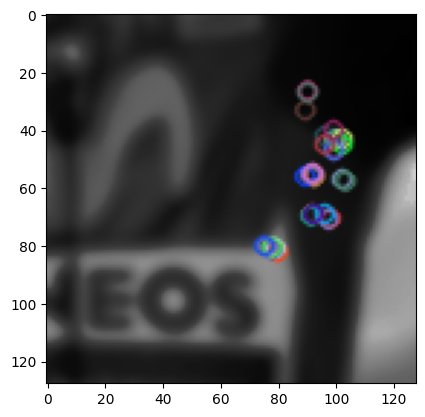

[]
[0] [0.27158324]


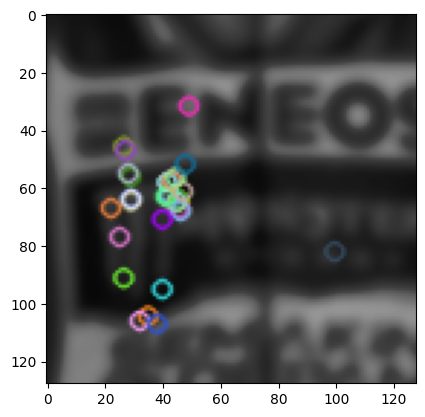

[]
[0] [0.18401631]


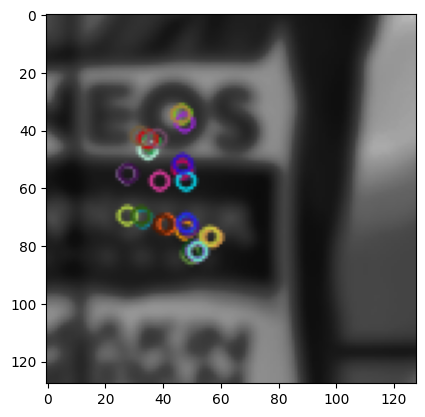

[]
[0] [0.32867866]


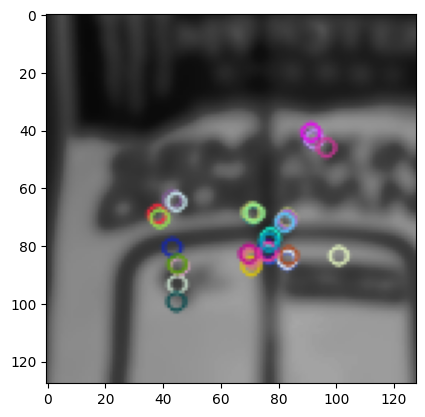

[]
[1] [0.76048816]


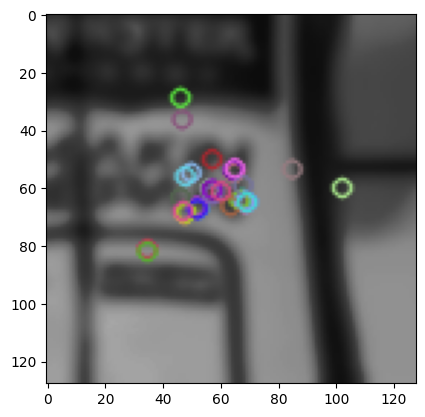

[[324.677632 449.691648]]


[array([324.677632, 449.691648])]

In [16]:
pipeline_save_path = pc.DATA_PATH+"/svm_model_3.pkl"
image_path = pc.DATA_PATH+"/final/Valentino_Rossi_2017.jpg"
pipeline = joblib.load(pipeline_save_path)
image = mpimg.imread(image_path)
keypoints, _ = pc.detect_faces(image, pipeline, method='ORB', threshold=0.65, window_size=(128, 128), step_size=(64, 64), n_keypoints=32, resize=False, verbose=True, notebook=True)
keypoints

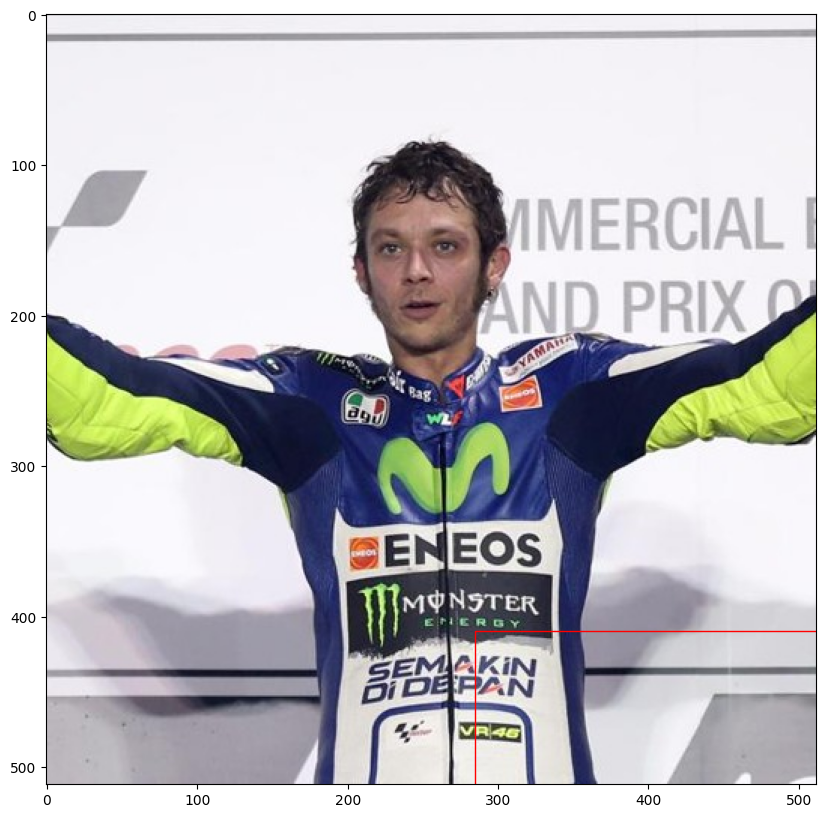

In [17]:
print_image(image, keypoints)
